# 1. Setup

In [1]:
import requests

from utils import *

# 2. ACS

## 2.1. Explore fields

### 2.1.1. Download fields

In [3]:
def get_acs_fields(year: int, five_year=True, table_type='B',
                   exclude_derivative_tables=True,
                   exclude_quality_vars=True,
                   exclude_detailed_tables=True,
                   save=True, overwrite=False):
    assert year <= 2021
    assert table_type in [None, 'B', 'C']
    outpath = Path(f'../data/ses/acs_{year}_fields.csv')
    if outpath.exists() and not overwrite:
        return pd.read_csv(outpath).set_index('fid')
    product = 'acs5' if five_year else 'acs1'
    url = f'https://api.census.gov/data/{year}/acs/{product}/variables'
    resp = requests.get(url)
    if resp.status_code != 200:
        raise ValueError('Could not fetch data: status code={}'
                        .format(resp.status_code))
    df = Pdf(resp.json()[4:], columns=['fid', 'fname', 'tname']).dropna()
    df = df[df.fid.str[0].isin(['B', 'C'])].dropna(subset='tname')
    df.fname = (df.fname.str.lower()
                .str.replace('!!', '__')
                .str.replace(':', '')
                .str.replace('estimate__', ''))
    df.tname = (df.tname.str.lower()
                .str.replace('in the past 12 months', 'last year')
                .str.replace('in the past year', 'last year')
                .str.replace(' years and over', '+ yr')
                .str.replace(f'in {year} inflation-adjusted dollars', 'in IA$'))
    df['tid'] = df.fid.str.split('_').str[0]
    df['fnum'] = df.fid.str.split('_').str[1].str[:-1]
    # filter only the given base tables
    if table_type:
        df = df[df.tid.str[0] == table_type]
    # remove derivative tables (that have suffixes in their IDs)
    if exclude_derivative_tables:
        df = df[df.tid.str[1:].str.isdigit()]
    # remove tables related to survey data quality
    if exclude_quality_vars:
        df = df[df.tid.str[1:3] <= '90']
    # remove detailed tables (they contain way too many variables!)
    if exclude_detailed_tables:
        df = df[~df.tname.str.startswith('detailed')]
    df = df.set_index('fid').sort_index()
    if save:
        df.to_csv(mkfile(outpath))
    return df
    
cols19 = get_acs_fields(year=2019, overwrite=0).disp(3)

13,624 rows x 4 cols; Memory: 5.1 MiB


,fname,tname,tid,fnum
fid,<object>,<object>,<object>,<int64>
B01001_001E,total,sex by age,B01001,1
B01001_002E,total__male,sex by age,B01001,2
B01001_003E,total__male__under 5 years,sex by age,B01001,3


### 2.1.2. Create field tree
Write a YAML file from the indents of the columns.
This may not always work since the input data indent structure could be flawed (e.g., in table B02016).

In [4]:
def make_field_tree(year: int, outfile='../data/ses/acs_{}_field_tree.yaml', 
                    overwrite=False):
    outpath = Path(outfile.format(year))
    if outpath.exists() and not overwrite:
        return
    cols = pd.read_csv(f'../data/ses/acs_{year}_fields.csv')
    cols['indent'] = cols.fname.str.split('__').str.len()
    cols['leaf'] = list(cols.indent.diff()[1:] <= 0) + [True]
    res = []
    for (tid, tname), df in cols.groupby(['tid', 'tname']):
        res.append(f'<{tid}> {tname}:')
        for _, r in df.iterrows():
            pfx = '  ' * r.indent + f'- <{r.fnum}>'
            name = r.fname.split('__')[-1]
            sfx = '' if r.leaf else ':'
            res.append(f'{pfx} {name}{sfx}')
    with open(outfile.format(year), 'w') as f:
        f.write('\n'.join(res))

make_field_tree(2019)

### 2.1.3. Define fields of interest

In [5]:
acs_cols = tuple(sorted([
    ## _Overall
    'B01001_001E', # total population
    'B19001_001E', # total households
    ## Age
    'B06001_002E', # population in the US aged ≤4 y
    'B16004_002E', # population of minors (aged 5-17 y)
    # 'B16004_046E', # population of seniors (aged ≥65 y)
    # 'B01002_001E', # median age of the entire population
    ## Commute mode
    # total workers aged ≥16 y by commute mode
    *[f'B08301_{x:03}E' for x in (1,10,18,19,21)],
    ## Disability
    # total civilian noninstitutionalized population by disability status
    *[f'B18135_{x:03}E' for x in (1,2,13,25)],
    # total households having received food stamps
    *[f'B22010_{x:03}E' for x in (1,3,6)],
    ## Education
    # total population aged ≥25 y by highest degree attained
    *[f'B15003_{x:03}E' for x in (1,18,19,20,21,22,23,24,25)],
    ## Employment
    'B23025_002E', # population of labor force (aged ≥16 y)
    'B23025_005E', # unemployed population in labor force
    ## Family
    # total households by family type
    *[f'B11012_{x:03}E' for x in (3,6,10,15)],
    ## Health insurance
    # total civilian noninstitutionalized population by health insurance coverage
    *[f'B27010_{x:03}E' for x in (1,17,33,50,66)],
    ## Housing
    # total population in occupied housing units by tenure
    *[f'B25033_{x:03}E' for x in (1,8,6,13)],
    # total housing units by occupants per room
    *[f'B25014_{x:03}E' for x in (1,5,6,7,11,12,13)],
    ## Income & poverty
    'B19301_001E', # median household income (inflation-adjusted USD)
    'B17021_001E', # total population for whom poverty status is determined
    'B17021_002E', # eligible population with income less than poverty level
    # total families with given income to poverty level ratio
    *[f'B17026_{x:03}E' for x in range(1, 10)],
    'B22010_002E', # total households having received food stamps/SNAP last year
    ## Language
    # total population aged ≥5 y by language spoken at home & English proficiency
    *[f'B16004_{x:03}E' for x in (1,7,8,12,13,17,18,22,23,29,30,34,35,39,40,44,45,51,52,56,57,61,62,66,67)],
    ## Race
    'B02001_002E', # total White population
    'B02001_003E', # total Black population
    ## Vehicle ownership
    # total occupied housing units by number of vehicles available
    *[f'B25044_{x:03}E' for x in (1,3,10)],
    'B25046_001E', # aggregate number of vehicles available
]))

## 2.2. Prepare data

### 2.2.1. Define derived features

- **Demographics**:
    - `POPU`: total population
    - `POP_DENSITY`: population density (per sq. mi.)
    - `P_MINOR`: proportion of popu aged ≤18 y
    - `P_POC`: proportion of people of color (non-White)
    - `P_LOWENGLISH`: proportion of population in limited English-speaking households
- **Economic**:
    - `M_INCOME`: per capita income in the last year, measured as the complement of the normalized log of  inflation-adjusted value in USD
    - `P_POV`: proportion of eligible population below poverty level
    - `P_POV150`: proportion of families with income less than 1.5 times poverty level
    - `P_POV200`: proportion of families with income less than 2 times poverty level
    - `P_SNAP`: proportion of households having received food stamps/SNAP last year
    - `P_UNEMPLOY`: proportion of labor force unemployed
- **Health & Education**:
    - `P_LOWEDU`: proportion people above 25 years with highest degree high shcool or lesser
    - `P_NOINSUR`: proportion of population without health insurance coverage
    - `P_DISABLED`: proportion of eligible population with a disability
- **House & Family**:
    - `P_SNGLPARENT`: proportion of households with children that are led by single parents
    - `P_CROWDED`: proportion of households that are crowded (>1.01 persons per room)
    - `P_RENTER`: proportion of housing units occupied by renters
    - `P_MOBILEHOME`: proportion of occupied housing units that are mobile homes
- **Transport**:
    - `P_NOVEH`: proportion of households not owning any vehicle
    - `M_HHPERVEH`: mean no. of households per vehicle
    - `P_NOWFH`: proportion of workers who do not (or cannot) work from home
    - `P_TRANSIT`: proportion of commuting workers using public transit
    - `P_WALKBIKE`: proportion of commuting workers who commute by walking or bicylcing

In [6]:
get_acs_ses = lambda x: dict(
    ## Overall
    popu = x.B01001_001E,
    ## Age
    # median age of population
    # m_age = x.B01002_001E,
    # proportion of popu aged ≤18 y
    p_minor = x.B16004_002E / x.B01001_001E,
    # proportion of popu aged ≥64 y
    # p_senior = x.B16004_046E / x.B01001_001E,
    ## Race
    # proportion people of color (non-White)
    p_poc = 1 - x.B02001_002E / x.B01001_001E,
    # proportion Black people
    # p_black = x.B02001_003E / x.B01001_001E,
    ## Education
    # proportion people above 25 years with highest degree high shcool or lesser
    p_lowedu = 1 - (x.B15003_018E + x.B15003_019E + x.B15003_020E + x.B15003_021E + x.B15003_022E + x.B15003_023E + x.B15003_024E + x.B15003_025E) / x.B15003_001E,
    ## Income & poverty
    # per capita income in the last year, measured as the complement 
    # of the normalized log of the inflation-adjusted value in USD
    m_income = 1 - normalize(np.log10(1 + x.B19301_001E)),
    # proportion of eligible population below poverty level
    p_pov = x.B17021_002E / x.B17021_001E,
    # proportion of families with income less than 1.5 times poverty level
    p_pov150 = (x.B17026_002E + x.B17026_003E + x.B17026_004E + x.B17026_005E + x.B17026_006E) / x.B17026_001E,
    # proportion of families with income less than 2 times poverty level
    p_pov200 = (x.B17026_002E + x.B17026_003E + x.B17026_004E + x.B17026_005E + x.B17026_006E + x.B17026_007E + x.B17026_008E + x.B17026_009E) / x.B17026_001E,
    # proportion of households having received food stamps/SNAP last year
    p_snap = x.B22010_002E / x.B19001_001E,
    ## Employment
    # proportion of labor force unemployed
    p_unemploy = x.B23025_005E / x.B23025_002E,
    ## Health & disability
    # proportion of population without health insurance
    p_noinsur = (x.B27010_017E + x.B27010_033E + x.B27010_050E + x.B27010_066E) / x.B27010_001E,
    # proportion of eligible population with a disability, including
    # difficulty in hearing, vision, cognition, self-car, indendent living, ambulation
    p_disabled = (x.B22010_003E + x.B22010_006E) / x.B22010_001E,
    ## Language
    # proportion of population in limited English-speaking households
    p_lowenglish = pd.concat([x[f'B16004_{i:03}E'] for i in (7, 8, 12, 13, 17, 18, 22, 23, 29, 30, 34, 35, 39, 40, 44, 45, 51, 52, 56, 57, 61, 62, 66, 67)], axis=1).sum(1) / x.B16004_001E,
    ## Family
    # proportion of households with children that are led by single parents
    p_snglparent = (x.B11012_010E + x.B11012_015E) / (x.B11012_003E + x.B11012_006E + x.B11012_010E + x.B11012_015E),
    # proportion of population living in institutionalized group quarters
    # p_grpquarter = x.B26103_003E / x.B26103_001E,
    p_crowded = (x.B25014_005E + x.B25014_006E + x.B25014_007E + x.B25014_011E + x.B25014_012E + x.B25014_013E) / x.B25014_001E,
    ## Housing
    # proportion of housing units occupied by renters
    p_renter = x.B25033_008E / x.B25033_001E,
    # proportion of occupied housing units that are mobile homes
    p_mobilehome = (x.B25033_006E + x.B25033_013E) / x.B25033_001E,
    ## Transport
    # proportion of households not owning any vehicle
    p_noveh = (x.B25044_003E + x.B25044_010E) / x.B25044_001E,
    # mean no. of households per vehicle
    m_hhperveh = x.B25044_001E / x.B25046_001E,
    # proportion of workers who do not (or cannot) work from home
    p_nowfh = 1 - (x.B08301_021E / x.B08301_001E),
    # proportion of commuting workers using public transit
    p_transit = x.B08301_010E / (x.B08301_001E - x.B08301_021E),
    # proportion of commuting workers who commute by walking or bicylcing
    p_walkbike = (x.B08301_018E + x.B08301_019E) / (x.B08301_001E - x.B08301_021E),
)

### 2.2.2. Download and process fields
API key requested from the Census Bureau on Nov 2, 2023 via [a form](https://api.census.gov/data/key_signup.html).

In [ ]:
def download_acs(geo, fields, src='acs5', year=2020, table_type='detail',
                 key='6bc2ce9d18094b273fb5f774799dfa9fdf6d366e'):
    """Download the data of the given ACS fields for a given region.

    Parameters
    ----------
    geo : list[tuple[str, str]]
        Regional geography defined as a list of subregions (e.g., a state is
        made of counties). The geographical hierarchy is to be defined as a list
        or tuple of 2-tuples: (geographical scale, search criteria). Here, the
        search criterion can be the FIPS code of the region or wildcard. E.g.,
        geo = [('state', '18'), ('county', '*')] for all counties in Indiana.
        For more details, see the API document:
        https://census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf
    fields : list[str]
        List of codes for the data fields of interest. E.g., ['B01001E',
        'C15027PR', ...]
    src : str
        Source of the dataset: must be one of {'acs1', 'acs5', 'acsse'}.
    year : int
        Year of the dataset.
    table_type : str
        Table type as defined by the US Census. Allowed values are the 1 or
        2-character codes as defined in the `id` column of `mk.acs.TABLE_TYPES`.
    key : str
        Census Data API key (optional but highly recommended).
    Returns
    -------
    pandas.DataFrame
        Table with the rows denoting the spatial units, the index denoting their
        identity hierarchy, and the columns named the same as :attr:`fields` and
        having the data values.
    """
    assert src in ['acs1', 'acs5', 'acsse', 'sf1']
    assert table_type in ['detail', 'profile', 'subject']
    geo_ = [(x[0].replace(' ', '+'), x[1]) for x in geo]
    for_ = '&for=' + ':'.join(geo_.pop(-1))
    in_ = '&in=' + '+'.join(':'.join(x) for x in geo_)
    key = f'&key={key}' if isinstance(key, str) else ''
    chunksize = 49
    root = 'https://api.census.gov/data'
    res = Pdf()
    for i in range(0, len(fields), chunksize):
        cols = fields[i : (i+chunksize)]
        get = 'get=' + ','.join(cols)
        url = f'{root}/{year}/acs/{src}?{get}{for_}{in_}{key}'
        resp = requests.get(url)
        try:
            data = resp.json()
            df = pd.DataFrame(data[1:], columns=data[0])
            id_cols = [x for x in df.columns if x not in cols]
            res = pd.concat([res, df.set_index(id_cols)], axis=1)
        except Exception as e:
            print('Failed fetching', cols)
            print(e)
    return res.astype(float)

In [9]:
def get_acs(rgn, year=2019, fields=acs_cols, overwrite=False):
    outpath = Path(f'../data/ses/acs_{rgn.lower()}_{year}.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    if isinstance(fields, str): fields = [fields]
    rgn, zone_year = rgn.lower(), (year // 10) * 10
    zones = gpd.read_parquet(f'../data/zones/{rgn}_{zone_year}.parquet')
    df = zones.query('scale == "COUNTY"')[['geoid']]
    df = df.assign(state=df.geoid.str[:2], county=df.geoid.str[2:5])
    df = df.groupby('state')['county'].agg(','.join)
    geos = {'COUNTY': [[('state', s), ('county', c)] for s, c in df.items()]}
    geos['TRACT'] = [x + [('tract', '*')] for x in geos['COUNTY']]
    geos['BG'] = [x + [('block group', '*')] for x in geos['TRACT']]
    geos = {k: v for k, v in geos.items() if k in zones['scale'].unique()}
    res = []
    for scale, geo_list in tqdm(geos.items()):
        for geos in geo_list:
            df = download_acs(geos, fields, year=year)
            df = df.reorder_levels([x[0] for x in geos])
            df = Pdf(get_acs_ses(df))
            df.insert(0, 'geoid', df.index.map(''.join))
            df.insert(0, 'scale', scale)
            if 'popu' in df:
                df = df[df['popu'] > 0]
            res.append(df)
    df = pd.concat(res).reset_index(drop=1)
    df = df.merge(zones[['geoid', 'aland']], on='geoid')
    df.insert(3, 'pop_density', df.popu / (df.pop('aland') / SQMI2SQM))
    df.to_parquet(mkfile(outpath))
    return df

# x = get_acs('IN', 2019, overwrite=1); x
acsIN19 = get_acs('IN', 2019, overwrite=0).disp() # t=0:12
# acsIN21 = get_acs('IN', 2021, overwrite=0).disp(0) # t=0:13
# acsMSA19 = get_acs('MSA', 2019, overwrite=0).disp(0) # t=3:10
acsMSA21 = get_acs('MSA', 2021, overwrite=0).disp(0) # t=3:20

6,407 rows x 25 cols; Memory: 1.9 MiB


,scale,geoid,popu,pop_density,p_minor,p_poc,p_lowedu,m_income,p_pov,p_pov150,p_pov200,p_snap,p_unemploy,p_noinsur,p_disabled,p_lowenglish,p_snglparent,p_crowded,p_renter,p_mobilehome,p_noveh,m_hhperveh,p_nowfh,p_transit,p_walkbike
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,COUNTY,18069,36359.0,95.018712,0.159328,0.041503,0.436188,0.78868,0.109009,0.147371,0.21833,0.084588,0.027811,0.078407,0.268824,0.003963,0.192825,0.009632,0.23065,0.020586,0.047144,0.504535,0.966263,0.001419,0.031736


42,907 rows x 25 cols; Memory: 12.8 MiB


,scale,geoid,popu,pop_density,p_minor,p_poc,p_lowedu,m_income,p_pov,p_pov150,p_pov200,p_snap,p_unemploy,p_noinsur,p_disabled,p_lowenglish,p_snglparent,p_crowded,p_renter,p_mobilehome,p_noveh,m_hhperveh,p_nowfh,p_transit,p_walkbike
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>


# 3. Visualize

## 3.1. Distributions

In [10]:
print('IN: {:,.0f}, MSA: {:,.0f}'.format(
    acsIN19.query('scale=="COUNTY"').popu.sum(),
    acsMSA21.query('scale=="COUNTY"').popu.sum()))

IN: 6,665,703, MSA: 180,237,050


In [14]:
acsMSA21['scale'].value_counts()

scale
TRACT     42455
COUNTY      452
Name: count, dtype: int64

## 3.2. Correlations

In [11]:
def plot_corr_matrix(acs):
    ax = pplot(size=(12, 12), dpi=200); ax.grid(alpha=0); ax.minorticks_off()
    df = acs.set_index('scale').rename(columns=str.upper).iloc[:, 1:]
    corr = np.triu(df.loc['COUNTY', :].corr(), 1) + np.tril(df.loc['TRACT', :].corr(), -1)
    corr = Pdf(corr, index=df.columns, columns=df.columns)
    np.fill_diagonal(corr.values, np.nan)
    sns.heatmap(corr, square=True, ax=ax, annot=True, fmt='.2f', 
                cmap='rainbow', vmax=.8, vmin=-.8,
                cbar_kws=D(shrink=0.7, label='Correlation'))
    ax.invert_xaxis()
    ax = pplot(ax, xlab='TRACT', ylab='COUNTY')
    for x in [0, 2, 3, 4, 5, 10, 11, 13, 14, 16, 18, 23]:
        ax.axhline(x, lw=2.5, color='k')
        ax.axvline(x, lw=2.5, color='k')

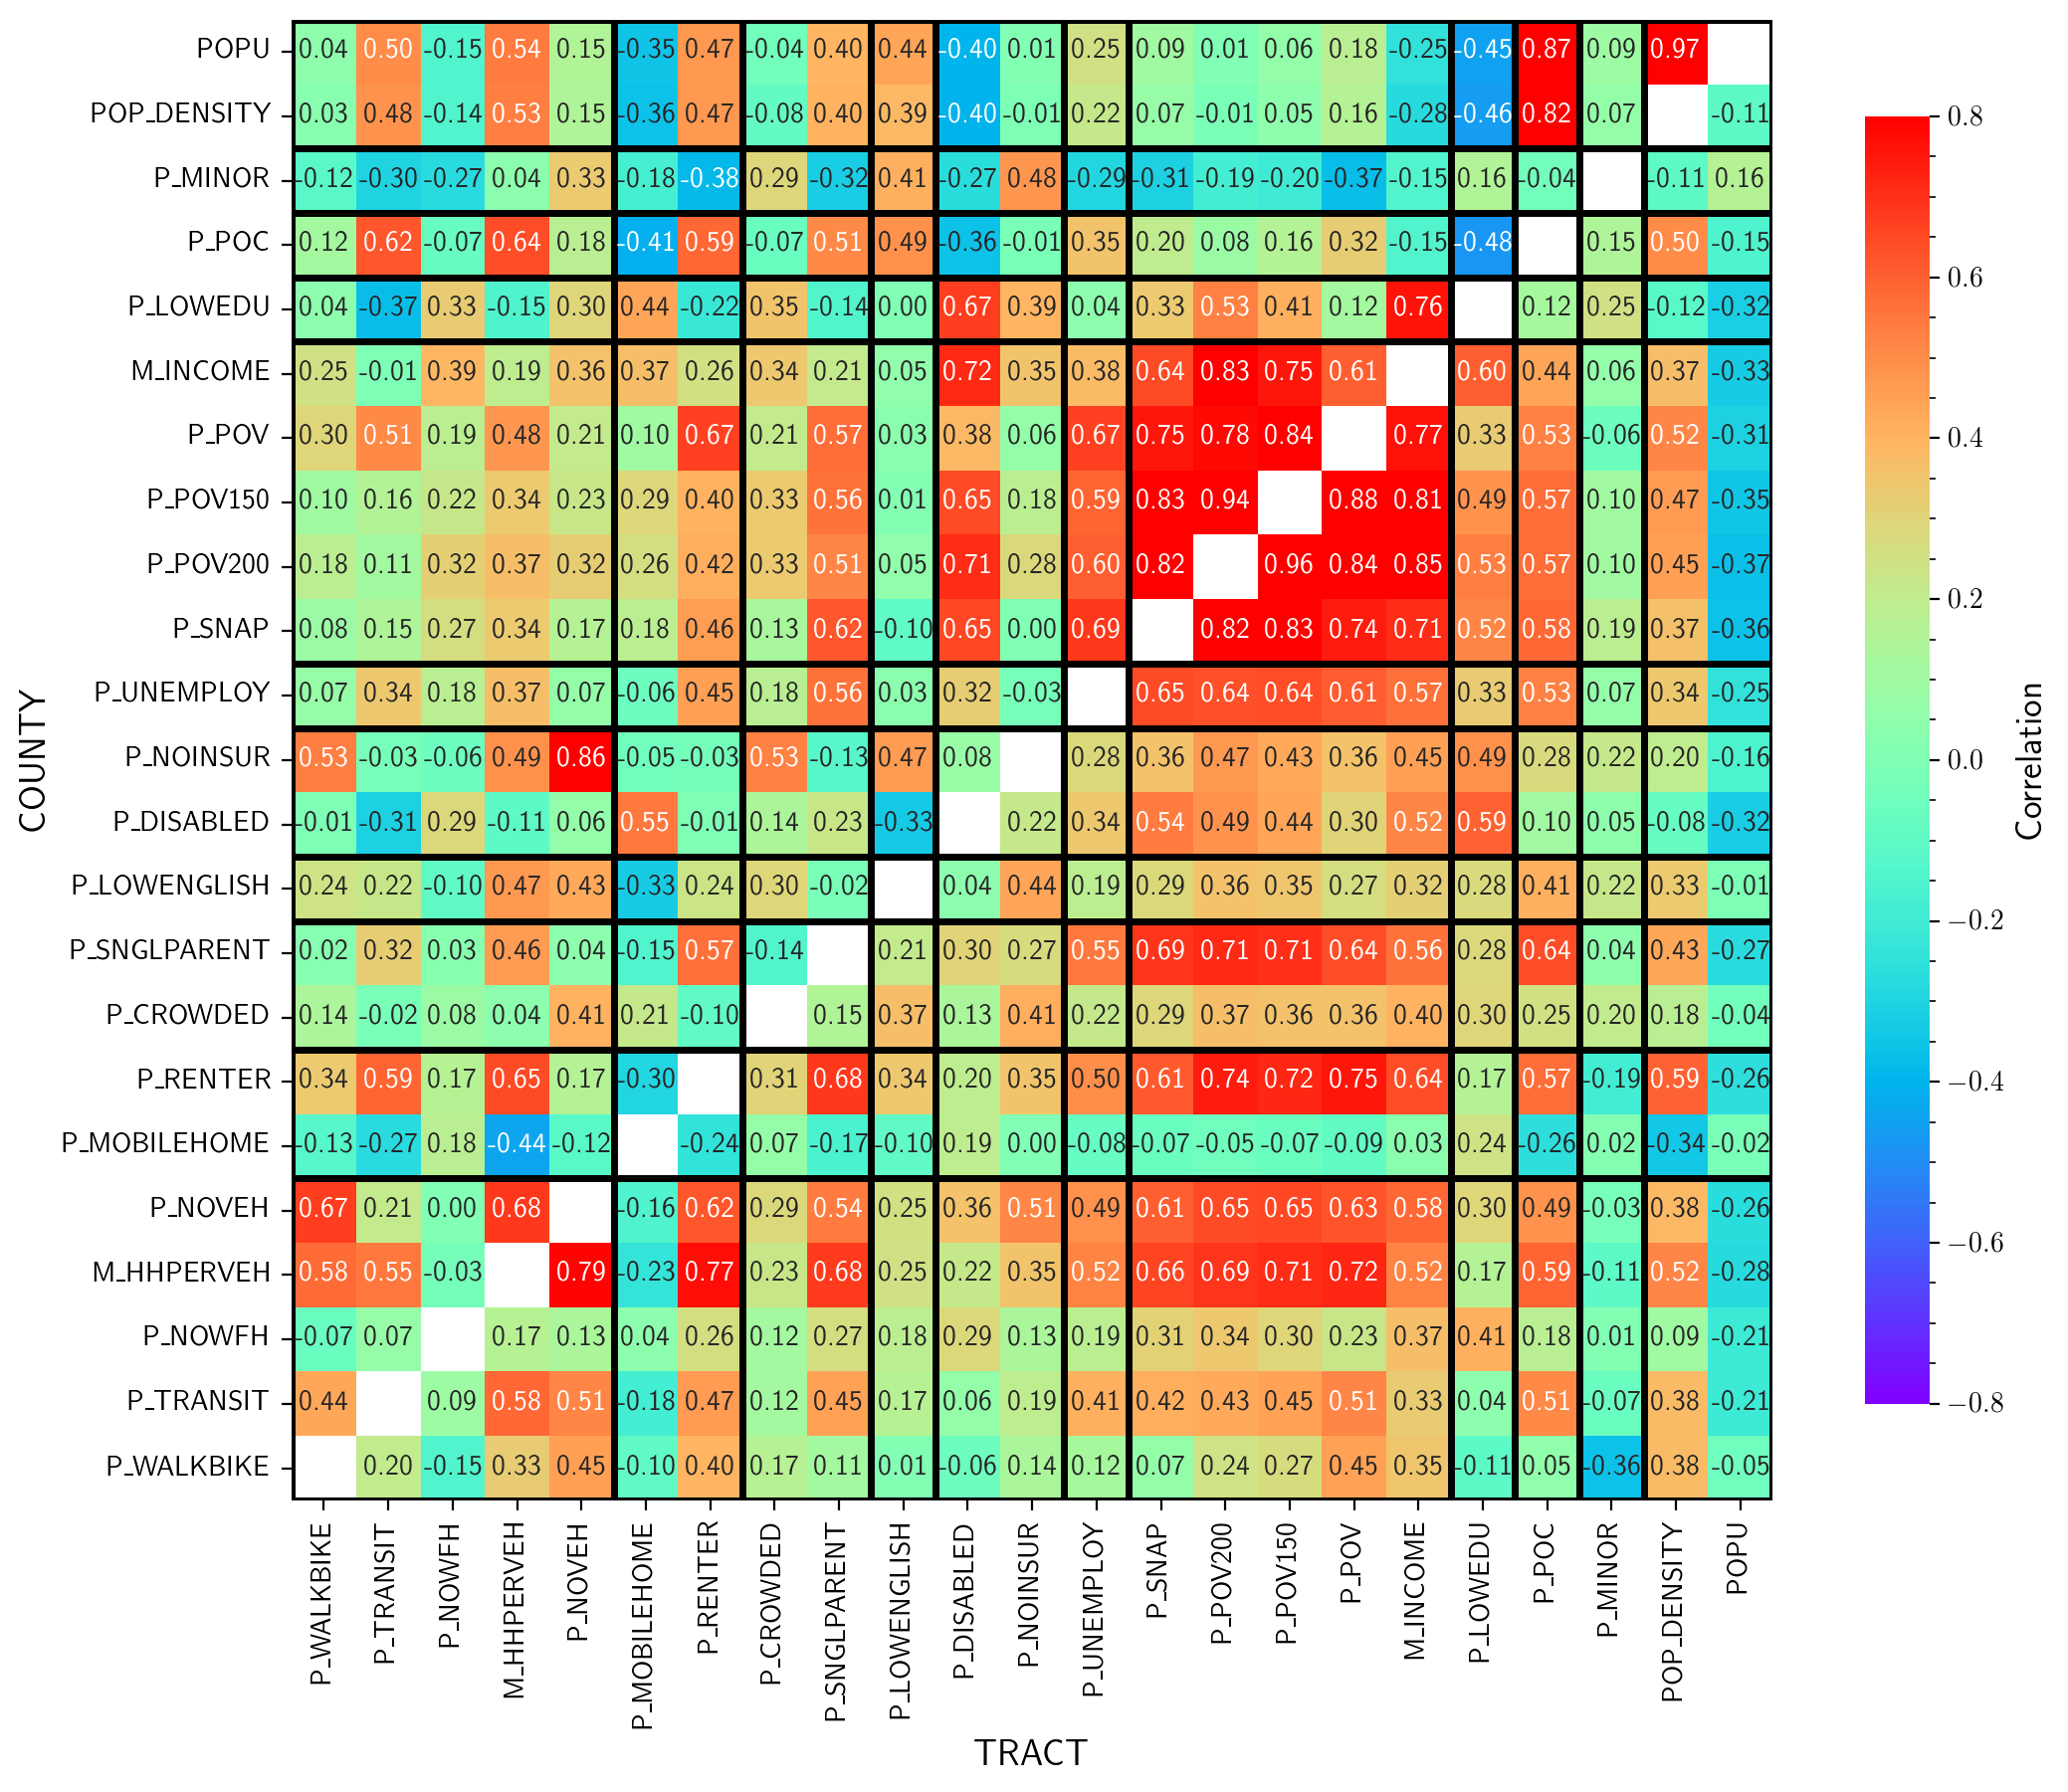

In [12]:
plot_corr_matrix(acsIN19)

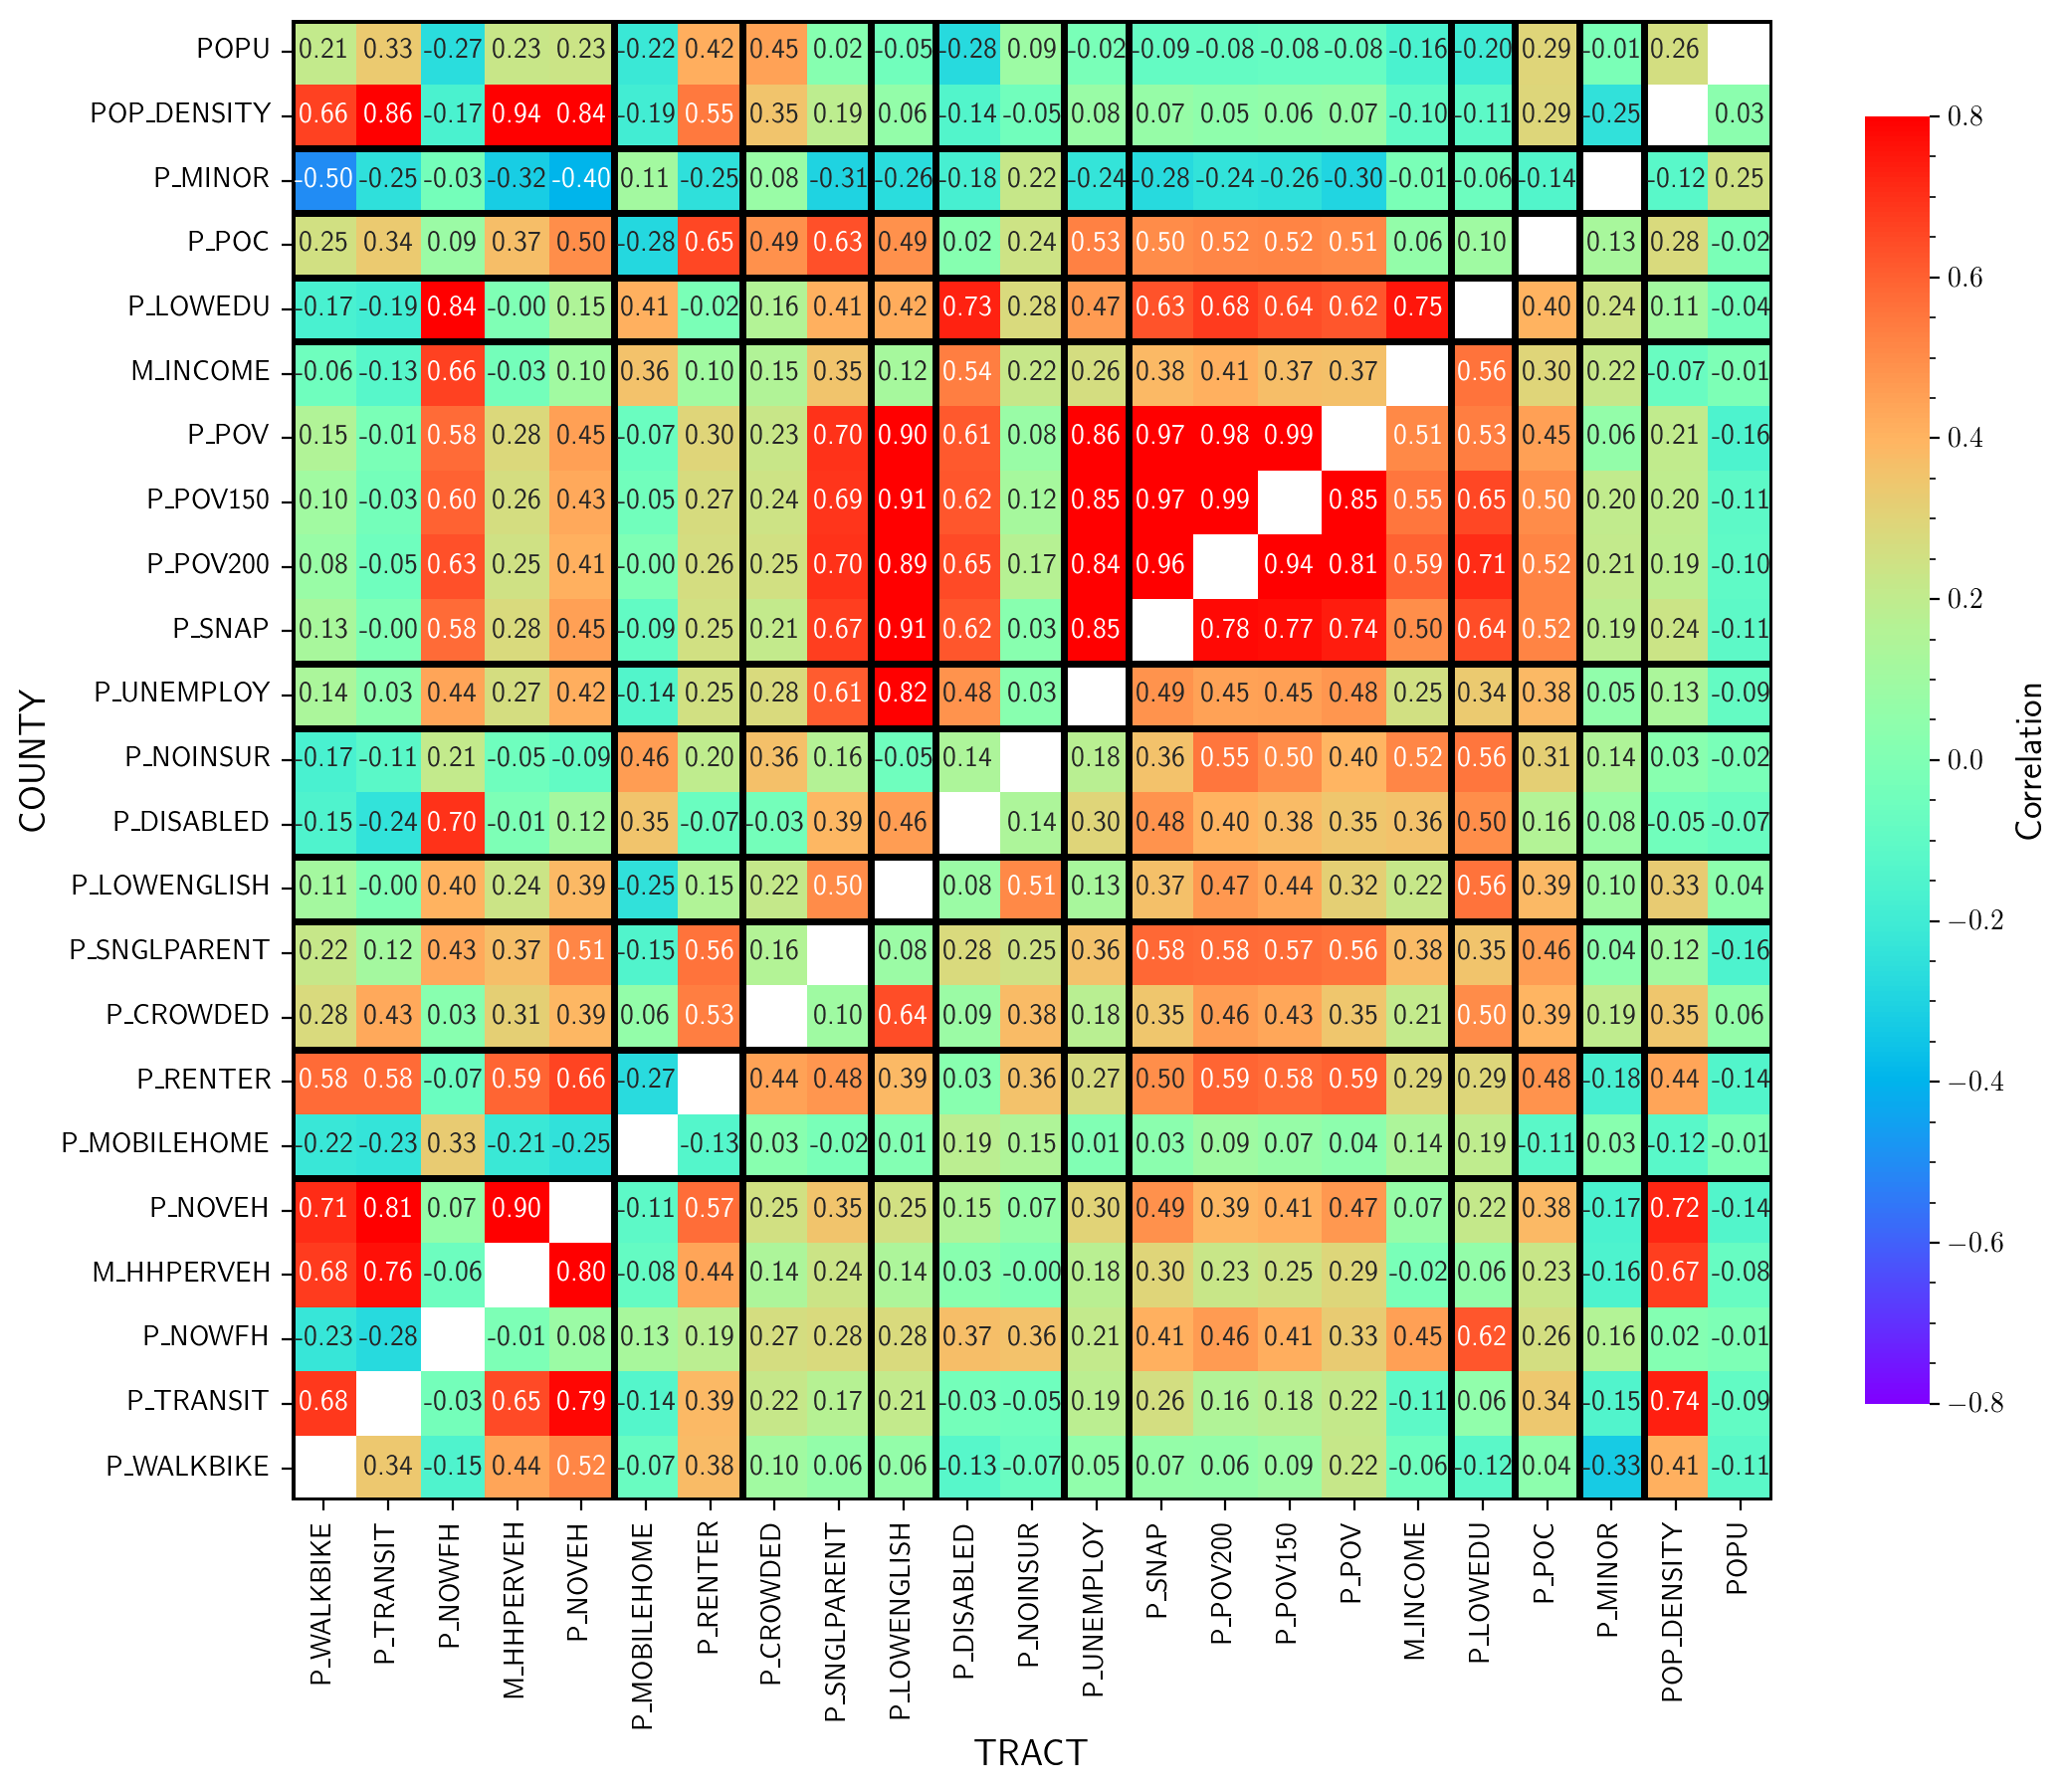

In [13]:
plot_corr_matrix(acsMSA21)

# 4. Social Vulnerability Index

## 4.1. Download
Downloaded CSV files from https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html at county & tract level.

## 4.2. Analyze

In [16]:
sviCt = pd.read_csv('../data/ses/svi_us_county_2020.csv').disp()

3,143 rows x 158 cols; Memory: 4.5 MiB


,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV150,M_POV150,E_UNEMP,M_UNEMP,E_HBURD,M_HBURD,E_NOHSDP,M_NOHSDP,E_UNINSUR,M_UNINSUR,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_LIMENG,M_LIMENG,E_MINRTY,M_MINRTY,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV150,MP_POV150,EP_UNEMP,MP_UNEMP,...,F_UNINSUR,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_LIMENG,F_THEME2,F_MINRTY,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_DAYPOP,E_NOINT,M_NOINT,E_AFAM,M_AFAM,E_HISP,M_HISP,E_ASIAN,M_ASIAN,E_AIAN,M_AIAN,E_NHPI,M_NHPI,E_TWOMORE,M_TWOMORE,E_OTHERRACE,M_OTHERRACE,EP_NOINT,MP_NOINT,EP_AFAM,MP_AFAM,EP_HISP,MP_HISP,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
,<int64>,<object>,<object>,<int64>,<object>,<int64>,<object>,<float64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<float64>,<float64>,<float64>,<float64>,...,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,1,Alabama,AL,1001,Autauga,1001,"Autauga County, Alabama",594.455838,55639,0,23697,68,21559,366,12611,1349,736,185,5029,576,4273,562,4345,725,8490,85,13143,49,9658,856,1608,302,363,229,14479,566,918,292,4313,440,339,162,1167,320,578,157,22.9,2.4,2.9,0.7,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41810,7100,913,10849,345,1601,0,649,174,155,102,0,29,1124,374,101,145,12.9,0.0,19.5,0.6,2.9,0.0,1.2,0.3,0.3,0.2,0.0,0.1,2.0,0.7,0.2,0.3


In [15]:
sviTr = pd.read_csv('../data/ses/svi_us_tract_2020.csv').disp()

84,122 rows x 158 cols; Memory: 122.2 MiB


,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV150,M_POV150,E_UNEMP,M_UNEMP,E_HBURD,M_HBURD,E_NOHSDP,M_NOHSDP,E_UNINSUR,M_UNINSUR,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_LIMENG,M_LIMENG,E_MINRTY,M_MINRTY,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV150,MP_POV150,EP_UNEMP,MP_UNEMP,...,F_UNINSUR,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_LIMENG,F_THEME2,F_MINRTY,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_DAYPOP,E_NOINT,M_NOINT,E_AFAM,M_AFAM,E_HISP,M_HISP,E_ASIAN,M_ASIAN,E_AIAN,M_AIAN,E_NHPI,M_NHPI,E_TWOMORE,M_TWOMORE,E_OTHERRACE,M_OTHERRACE,EP_NOINT,MP_NOINT,EP_AFAM,MP_AFAM,EP_HISP,MP_HISP,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
,<int64>,<object>,<object>,<int64>,<object>,<int64>,<object>,<float64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<float64>,<float64>,<float64>,<float64>,...,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,1,Alabama,AL,1001,Autauga,1001020100,"Census Tract 201, Autauga County, Alabama",3.79357,1941,390,710,120,693,121,352,138,18,18,144,59,187,93,187,91,295,101,415,208,413,147,51,31,0,48,437,192,0,16,88,43,0,16,10,12,0,12,18.1,6.1,2.1,2.1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1033,217,544,235,151,33,34,41,54,0,12,0,12,128,99,0,12,11.2,2.3,12.1,7.1,1.7,1.8,2.1,2.7,0.0,1.8,0.0,1.8,6.6,5.1,0.0,1.8
